#Nikhil Kumar
#2018bcs0040

# Implementing K-medoids algorithm

In [3]:
from scipy.sparse import csr_matrix
import numpy as np
import random

class KMedoids:
    def __init__(self, n_cluster=2, max_iter=10, tol=0.1, start_prob=0.8, end_prob=0.99):
        if start_prob < 0 or start_prob >= 1 or end_prob < 0 or end_prob >= 1 or start_prob > end_prob:
            raise ValueError('Invalid input')
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.tol = tol
        self.start_prob = start_prob
        self.end_prob = end_prob
        
        self.medoids = []
        self.clusters = {}
        self.tol_reached = float('inf')
        self.current_distance = 0
        
        self.__data = None
        self.__is_csr = None
        self.__rows = 0
        self.__columns = 0
        self.cluster_distances = {}
        
        
    def fit(self, data):
        self.__data = data
        self.__set_data_type()     
        self.__start_algo()
        return self
    
    def __start_algo(self):
        self.__initialize_medoids()
        self.clusters, self.cluster_distances = self.__calculate_clusters(self.medoids)
        self.__update_clusters()
 
    def __update_clusters(self):
        for i in range(self.max_iter):
            cluster_dist_with_new_medoids = self.__swap_and_recalculate_clusters()
            if self.__is_new_cluster_dist_small(cluster_dist_with_new_medoids) == True:
                self.clusters, self.cluster_distances = self.__calculate_clusters(self.medoids)
            else:
                break

    def __is_new_cluster_dist_small(self, cluster_dist_with_new_medoids):
        existance_dist = self.calculate_distance_of_clusters()
        new_dist = self.calculate_distance_of_clusters(cluster_dist_with_new_medoids)
        
        if existance_dist > new_dist and (existance_dist - new_dist) > self.tol:
            self.medoids = cluster_dist_with_new_medoids.keys()
            return True
        return False
    
    def calculate_distance_of_clusters(self, cluster_dist=None):
        if cluster_dist == None:
            cluster_dist = self.cluster_distances
        dist = 0
        for medoid in cluster_dist.keys():
            dist += cluster_dist[medoid]
        return dist
        
    def __swap_and_recalculate_clusters(self):
        cluster_dist = {}
        for medoid in self.medoids:
            is_shortest_medoid_found = False
            for data_index in self.clusters[medoid]:
                if data_index != medoid:
                    cluster_list = list(self.clusters[medoid])
                    cluster_list[self.clusters[medoid].index(data_index)] = medoid
                    new_distance = self.calculate_inter_cluster_distance(data_index, cluster_list)
                    if new_distance < self.cluster_distances[medoid]:
                        cluster_dist[data_index] = new_distance
                        is_shortest_medoid_found = True
                        break
            if is_shortest_medoid_found == False:
                cluster_dist[medoid] = self.cluster_distances[medoid]
        return cluster_dist
    
    def calculate_inter_cluster_distance(self, medoid, cluster_list):
        distance = 0
        for data_index in cluster_list:
            distance += self.__get_distance(medoid, data_index)
        return distance/len(cluster_list)
        
    def __calculate_clusters(self, medoids):
        clusters = {}
        cluster_distances = {}
        for medoid in medoids:
            clusters[medoid] = []
            cluster_distances[medoid] = 0
            
        for row in range(self.__rows):
            nearest_medoid, nearest_distance = self.__get_shortest_distance_to_mediod(row, medoids)
            cluster_distances[nearest_medoid] += nearest_distance
            clusters[nearest_medoid].append(row)
        
        for medoid in medoids:
            cluster_distances[medoid] /= len(clusters[medoid])
        return clusters, cluster_distances
        
        
    def __get_shortest_distance_to_mediod(self, row_index, medoids):
        min_distance = float('inf')
        current_medoid = None
        
        for medoid in medoids:
            current_distance = self.__get_distance(medoid, row_index)
            if current_distance < min_distance:
                min_distance = current_distance
                current_medoid = medoid
        return current_medoid, min_distance

    def __initialize_medoids(self):
        '''Kmeans++ initialisation'''
        self.medoids.append(random.randint(0,self.__rows-1))
        while len(self.medoids) != self.n_cluster:
            self.medoids.append(self.__find_distant_medoid())
    
    def __find_distant_medoid(self):
        distances = []
        indices = []
        for row in range(self.__rows):
            indices.append(row)
            distances.append(self.__get_shortest_distance_to_mediod(row,self.medoids)[1])
        distances_index = np.argsort(distances)
        choosen_dist = self.__select_distant_medoid(distances_index)
        return indices[choosen_dist]
    
    def __select_distant_medoid(self, distances_index):
        start_index = round(self.start_prob*len(distances_index))
        end_index = round(self.end_prob*(len(distances_index)-1)) 
        return distances_index[random.randint(start_index, end_index)]

                           
    def __get_distance(self, x1, x2):
        a = self.__data[x1].toarray() if self.__is_csr == True else np.array(self.__data[x1])
        b = self.__data[x2].toarray() if self.__is_csr == True else np.array(self.__data[x2])
        return np.linalg.norm(a-b)
    
    def __set_data_type(self):
        '''to check whether the given input is of type "list" or "csr" '''
        if isinstance(self.__data,csr_matrix):
            self.__is_csr = True
            self.__rows = self.__data.shape[0]
            self.__columns = self.__data.shape[1]
        elif isinstance(self.__data,list):
            self.__is_csr = False
            self.__rows = len(self.__data)
            self.__columns = len(self.__data[0])
        else:
            raise ValueError('Invalid input')    

In [4]:
data = [[4, 7], [5, 2], [8, 8], [0, 3], [9, 1], [2, 7], [3, 0], [7, 1], [8, 2], [4, 0]]
k_medoids = KMedoids(n_cluster=2)
k_medoids.fit(data)

In [5]:
import matplotlib.pyplot as plt

In [6]:

def plot_graphs(data, k_medoids):
    colors = {0:'b*', 1:'g^',2:'ro',3:'c*', 4:'m^', 5:'yo', 6:'ko', 7:'w*'}
    index = 0
    for key in k_medoids.clusters.keys():
        temp_data = k_medoids.clusters[key]
        x = [data[i][0] for i in temp_data]
        y = [data[i][1] for i in temp_data]
        plt.plot(x, y, colors[index])
        index += 1
    plt.title('Cluster formations')
    plt.show()

    medoid_data_points = []
    for m in k_medoids.medoids:
        medoid_data_points.append(data[m])   
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    x_ = [i[0] for i in medoid_data_points]
    y_ = [i[1] for i in medoid_data_points]
    plt.plot(x, y, 'yo')
    plt.plot(x_, y_, 'r*')
    plt.title('Mediods are highlighted in red')
    plt.show()


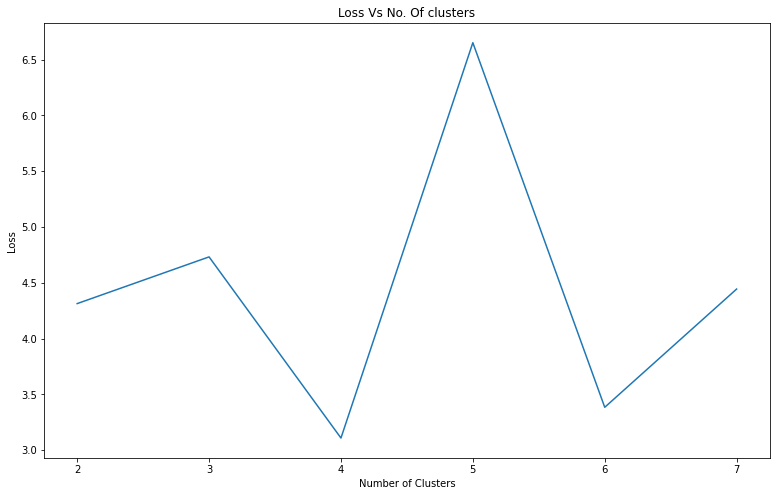

In [8]:
data_ = [
    [5.2, 3.7],[5.1,4.1], [9., 1.2], [5, 3.7], [5.3, 4], [5.5, 3.8], [5,4], [4.7, 3.7], [7.8, 4], [4.7, 3.3], [5.2, 3.3],[4.9,3.4], [5.3,3.5]
    ,[2.6, 1.5],[0.6, 10.2],[2.7, 1],[2.4,1.7],[2.6, 1.5],[2.7, 1.8], [2.1, 1.1], [9.2, 1.7], [5.3,8.8], [2.5, 11.3], [2.5,2]
    , [3, 3.5], [3.5, 3.8], [3.3, 5.2], [4.5, 1.9], [4.3, 1.4], [4, 2]
]
n_clusters = range(2,8)
k_medoids = [KMedoids(n_cluster=i) for i in n_clusters]
k_medoids = [k_medoid.fit(data_) for k_medoid in k_medoids]
loss = [k_medoid.calculate_distance_of_clusters() for k_medoid in k_medoids]


plt.figure(figsize=(13,8))
plt.plot(n_clusters,loss)
plt.xticks(n_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Loss')
plt.title('Loss Vs No. Of clusters')
plt.show()

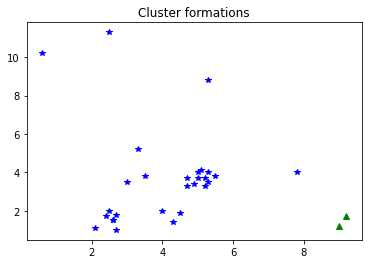

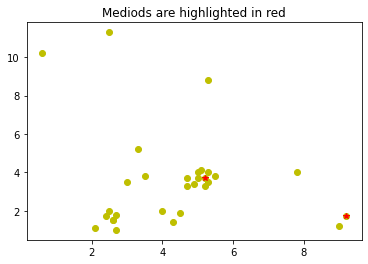

In [9]:
k_medoids = KMedoids(n_cluster=2)
k_medoids.fit(data_)
plot_graphs(data_, k_medoids);

### Example

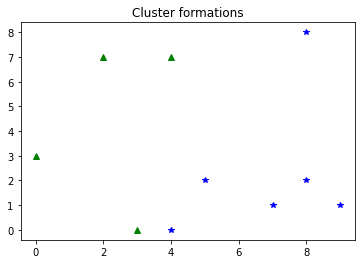

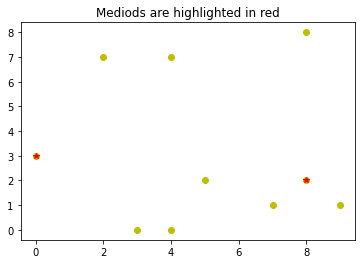

In [10]:
data =  [[4, 7], [5, 2], [8, 8], [0, 3], [9, 1], [2, 7], [3, 0], [7, 1], [8, 2], [4, 0]]
k_medoids = KMedoids(n_cluster=2)
k_medoids.fit(data)
plot_graphs(data, k_medoids)